In [1]:
import numpy as np
import pandas as pd
from numpy.random import seed
seed(30)
#import tensorflow as tf
#tf.random.set_seed(30)
df = pd.read_pickle(r'./combined_data_feb2023.pkl')

In [2]:
features = ['Ward Glucose', 'Haemoglobin',
       'Mean cell volume, blood', 'White blood cell count, blood',
       'Haematocrit', 'Platelets', 'Urea level, blood', 'Creatinine', 'Sodium',
       'Potassium', 'Lymphocytes', 'Neutrophils', 'C-Reactive Protein',
       'Eosinophils', 'Alkaline Phosphatase', 'Albumin',
       'Alanine Transaminase', 'Bilirubin', 'Total Protein',
       'Fibrinogen (clauss)', 'Glucose POCT Strip Blood', 'Ferritin',
       'D-Dimer', 'Ward Lactate', 'age', 'sex', 'SARS CoV-2 RNA']

In [3]:
df['missing']=df[features].isnull().sum(axis=1)/24
list_HAI = df[(df['date_diff']==-2)&(df['missing']<1)\
|(df['date_diff']==-3)&(df['missing']<1)\
|(df['date_diff']==-4)&(df['missing']<1)\
|(df['date_diff']==-5)&(df['missing']<1)\
|(df['date_diff']==-6)&(df['missing']<1)\
|(df['date_diff']==-7)&(df['missing']<1)]['id'].unique()
display(list_HAI)
display(len(list_HAI))

array([    1,     2,     3, ..., 20845, 20846, 20847])
4933

In [4]:
start_date = '2014-1-1'
train_date = '2020-12-1'
val_date = '2021-03-1'

train = df[(df['date_culture']>=start_date)&(df['date_culture']<train_date)]

val = df[(df['date_culture']>=train_date)&(df['date_culture']<val_date)]

test = df[df['date_culture']>=val_date]

display('Train')
display(train['pathogenic'].value_counts(normalize=True))
display(len(train.groupby(['id','date_culture'])))

display('Val')
display(val['pathogenic'].value_counts(normalize=True))
display(len(val.groupby(['id','date_culture'])))

display('Test')
display(test['pathogenic'].value_counts(normalize=True))
display(len(test.groupby(['id','date_culture'])))

'Train'
pathogenic
0.0    0.761944
1.0    0.238056
Name: proportion, dtype: float64
13354
'Val'
pathogenic
0.0    0.885361
1.0    0.114639
Name: proportion, dtype: float64
1858
'Test'
pathogenic
0.0    0.915928
1.0    0.084072
Name: proportion, dtype: float64

5638

In [5]:
def scale_data(train_data, val_data, test_data, feature_list):
   
    from sklearn.preprocessing import MinMaxScaler
    scale = MinMaxScaler(feature_range=(-1,1))
    
    train_scaled=train_data.copy()
    train_scaled[feature_list] = scale.fit_transform(train_scaled[feature_list])
    
    val_scaled = val_data.copy()
    val_scaled[feature_list]=scale.transform(val_scaled[feature_list])

    test_scaled = test_data.copy()
    test_scaled[feature_list] = scale.transform(test_scaled[feature_list])

    return train_scaled, val_scaled, test_scaled


train_scaled, val_scaled, test_scaled = scale_data(train, val, test, features)

#Fillna(0) done after scaling
train_scaled = train_scaled.fillna(0)
val_scaled = val_scaled.fillna(0)
test_scaled = test_scaled.fillna(0)
# Reshape function takes features listed above and slices them into train, test sets and reshapes to (samples,steps,features)

def reshape(data):
    data_samples = len(data.groupby('id'))
    data_steps = len(data)/ len(data.groupby(['id']))
    data_steps = int(data_steps)
    data_feature_size = len(data[features].columns)

    data_features = data[features].fillna(0).values.reshape(data_samples,data_steps,data_feature_size)
    y_data = data.groupby(['id'])['pathogenic'].max().astype(int).values 

    return data_features, y_data

X_train, y_train = reshape(train_scaled)
X_val, y_val = reshape(val_scaled)
X_test, y_test = reshape(test_scaled)

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import LSTM
from keras import regularizers
from keras.layers import BatchNormalization
import tensorflow as tf

model_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)
    ]

model = Sequential()
model.add(tf.keras.layers.Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(10, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(10))
model.add(Dense(1, activation= 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC(from_logits=True, name='auc')])

history = model.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=30, batch_size=64, callbacks=model_callbacks)

2023-09-26 15:50:02.450952: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 15:50:03.293321: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-26 15:50:04.228375: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/30
209/209 [==============================] - 12s 26ms/step - loss: 0.3977 - auc: 0.8632 - val_loss: 0.2528 - val_auc: 0.9080
Epoch 2/30
209/209 [==============================] - 3s 16ms/step - loss: 0.3006 - auc: 0.9157 - val_loss: 0.1894 - val_auc: 0.9413
Epoch 3/30
209/209 [==============================] - 3s 16ms/step - loss: 0.2808 - auc: 0.9216 - val_loss: 0.1670 - val_auc: 0.9562
Epoch 4/30
209/209 [==============================] - 3s 15ms/step - loss: 0.2742 - auc: 0.9270 - val_loss: 0.1651 - val_auc: 0.9567
Epoch 5/30
209/209 [==============================] - 3s 15ms/step - loss: 0.2712 - auc: 0.9293 - val_loss: 0.1645 - val_auc: 0.9571
Epoch 6/30
209/209 [==============================] - 4s 21ms/step - loss: 0.2702 - auc: 0.9308 - val_loss: 0.1602 - val_auc: 0.9567

In [6]:
from functions.tools import metrics

177/177 [==============================] - 3s 3ms/step
Best Threshold=0.112451
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      5164
           1       0.56      0.99      0.71       474

    accuracy                           0.93      5638
   macro avg       0.78      0.96      0.84      5638
weighted avg       0.96      0.93      0.94      5638

Specificity 0.9273818745158792
Sensitivity 0.9936708860759493
ROC score 0.9761828890043698
AP 0.697022021705726
PPV 0.5567375886524822
NPV 0.9993739565943238
BS 0.03487272432405408
AUPRC 0.697022021705726


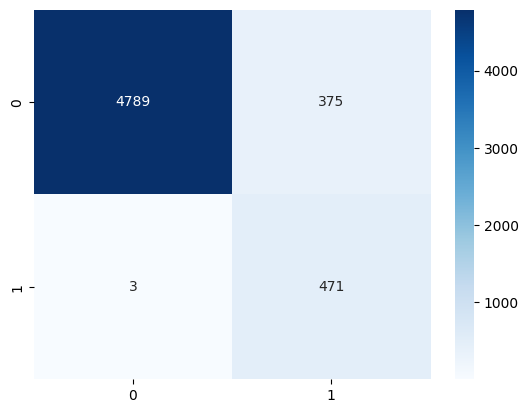

In [7]:
predictions = model.predict(X_test)
metrics(predictions, y_test)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

y_pred_prob = model.predict(X_test).flatten()

177/177 [==============================] - 1s 4ms/step


In [9]:
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)

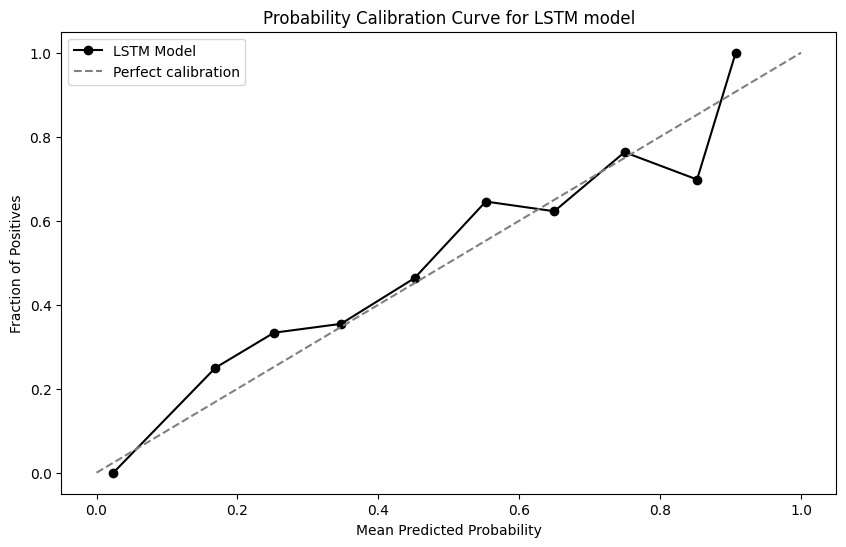

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', color='black', label='LSTM Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Probability Calibration Curve for LSTM model')
plt.legend()
plt.show()

In [11]:
predictions_class = predictions >=0.048272

In [12]:
# This is the dataframe of predictions vs truth for the test set, for each window, and the actual continuous probability output
# This is indexed in the order they appear in test_set (verified)

matrix = pd.concat([pd.DataFrame(predictions_class.astype(int)), pd.DataFrame(y_test.astype(int))],axis=1)
matrix['model_prediction'] = predictions
matrix.columns=['predicted','actual', 'model_prediction']
matrix

,predicted,actual,model_prediction
0,1,1,0.424742
1,1,0,0.705653
2,1,1,0.291744
3,1,1,0.878641
4,1,1,0.368397
...,...,...,...
5633,1,0,0.418400
5634,1,1,0.841645
5635,1,1,0.447847
5636,0,0,0.024799


In [13]:
# This is the original dataframe which contains the details of the test set
test_template = test

In [14]:
details = test_template.groupby(['id']).agg({
                    'organisms':'first',
                    'ETHNICITY_DESC' :'first',
                    'MAIN_SPECIALTY_CODE_DESC':'first',
                    'sex':'first',
                    'age':'first'
                
})

In [15]:
details = details.reset_index()
error_grid = pd.concat([matrix, details],axis=1)

In [17]:
error_grid['HAI'] = error_grid['id'].isin(list_HAI)

In [18]:
error_grid['HAI']=error_grid['HAI'].astype(int)

In [20]:
error_grid.loc[(error_grid['predicted']==0)&(error_grid['actual']==0), 'interpret']='TN'
error_grid.loc[(error_grid['predicted']==1)&(error_grid['actual']==1), 'interpret']='TP'
error_grid.loc[(error_grid['predicted']==0)&(error_grid['actual']==1), 'interpret']='FN'
error_grid.loc[(error_grid['predicted']==1)&(error_grid['actual']==0), 'interpret']='FP'

In [21]:
error_grid.loc[(error_grid['predicted']==error_grid['actual']), 'accurate'] =1 
error_grid.loc[(error_grid['predicted']!=error_grid['actual']), 'accurate'] =0


In [22]:
#Functions to generate summary tables - spec, sens, accuracy:
def summarise(var):
    spec_sens = pd.crosstab(error_grid['interpret'], error_grid[var]).T
    spec_sens['sensivity'] = spec_sens['TP']/(spec_sens['TP']+spec_sens['FN'])
    spec_sens['specificity'] = spec_sens['TN']/(spec_sens['TN']+spec_sens['FP'])

    accurate = pd.crosstab(error_grid['accurate'],error_grid[var]).T.apply(lambda x: x/sum(x), axis=1)
    combined = pd.concat([spec_sens,accurate],axis=1)

    return combined


In [23]:
summarise('organisms')

,FN,FP,TN,TP,sensivity,specificity,0.0,1.0
organisms,,,,,,,,
Citrobacter spp,0,0,0,6,1.000000,NaN,0.000000,1.000000
CoNS,0,338,5,0,NaN,0.014577,0.985423,0.014577
Corynebacterium spp,0,17,0,0,NaN,0.000000,1.000000,0.000000
E. coli,1,0,0,162,0.993865,NaN,0.006135,0.993865
Enterobacter spp,0,0,0,14,1.000000,NaN,0.000000,1.000000
Enterococcus spp,0,0,0,51,1.000000,NaN,0.000000,1.000000
Klebsiella spp,0,0,0,57,1.000000,NaN,0.000000,1.000000
Micrococcus spp,0,24,0,0,NaN,0.000000,1.000000,0.000000
No growth,0,493,4287,0,NaN,0.896862,0.103138,0.896862


In [24]:
summarise('HAI')

,FN,FP,TN,TP,sensivity,specificity,0.0,1.0
HAI,,,,,,,,
0,1,658,4292,210,0.995261,0.867071,0.127688,0.872312
1,0,214,0,263,1.000000,0.000000,0.448637,0.551363


In [25]:
from scipy.stats import mannwhitneyu
display(error_grid.groupby('accurate')['age'].describe()[['25%','50%','75%']])
display(mannwhitneyu(error_grid[error_grid['accurate']==1]['age'],error_grid[error_grid['accurate']==0]['age']))


,25%,50%,75%
accurate,,,
0.0,0.0,3.0,52.0
1.0,31.0,53.0,71.0


MannwhitneyuResult(statistic=3089873.0, pvalue=1.2632385661705937e-115)

In [26]:
display(error_grid.groupby('actual')['age'].describe())
display(mannwhitneyu(error_grid[error_grid['actual']==1]['age'],error_grid[error_grid['actual']==0]['age']))

,count,mean,std,min,25%,50%,75%,max
actual,,,,,,,,
0,5164.0,44.808624,28.006837,0.0,24.0,47.0,68.0,121.0
1,474.0,58.658378,22.840379,0.0,47.0,64.0,76.0,98.0


MannwhitneyuResult(statistic=1577451.5, pvalue=1.7768776740440265e-25)

In [27]:
# Bootstrapping function from https://mateuszbuda.github.io/2019/04/30/stat.html
# Sampling with replacement of predictions and actual pairs x 2000

import numpy as np
from scipy.stats import percentileofscore


def score_ci(
    y_true,
    y_pred,
    score_fun,
    sample_weight=None,
    n_bootstraps=2000,
    confidence_level=0.95,
    seed=None,
    reject_one_class_samples=True,
):
    """
    Compute confidence interval for given score function based on labels and predictions using bootstrapping.
    :param y_true: 1D list or array of labels.
    :param y_pred: 1D list or array of predictions corresponding to elements in y_true.
    :param score_fun: Score function for which confidence interval is computed. (e.g. sklearn.metrics.accuracy_score)
    :param sample_weight: 1D list or array of sample weights to pass to score_fun, see e.g. sklearn.metrics.roc_auc_score.
    :param n_bootstraps: The number of bootstraps. (default: 2000)
    :param confidence_level: Confidence level for computing confidence interval. (default: 0.95)
    :param seed: Random seed for reproducibility. (default: None)
    :param reject_one_class_samples: Whether to reject bootstrapped samples with only one label. For scores like AUC we
    need at least one positive and one negative sample. (default: True)
    :return: Score evaluated on labels and predictions, lower confidence interval, upper confidence interval, array of
    bootstrapped scores.
    """

    assert len(y_true) == len(y_pred)

    score = score_fun(y_true, y_pred)
    _, ci_lower, ci_upper, scores = score_stat_ci(
        y_true=y_true,
        y_preds=y_pred,
        score_fun=score_fun,
        sample_weight=sample_weight,
        n_bootstraps=n_bootstraps,
        confidence_level=confidence_level,
        seed=seed,
        reject_one_class_samples=reject_one_class_samples,
    )

    return score, ci_lower, ci_upper, scores


def score_stat_ci(
    y_true,
    y_preds,
    score_fun,
    stat_fun=np.mean,
    sample_weight=None,
    n_bootstraps=2000,
    confidence_level=0.95,
    seed=None,
    reject_one_class_samples=True,
):
    """
    Compute confidence interval for given statistic of a score function based on labels and predictions using
    bootstrapping.
    :param y_true: 1D list or array of labels.
    :param y_preds: A list of lists or 2D array of predictions corresponding to elements in y_true.
    :param score_fun: Score function for which confidence interval is computed. (e.g. sklearn.metrics.accuracy_score)
    :param stat_fun: Statistic for which confidence interval is computed. (e.g. np.mean)
    :param sample_weight: 1D list or array of sample weights to pass to score_fun, see e.g. sklearn.metrics.roc_auc_score.
    :param n_bootstraps: The number of bootstraps. (default: 2000)
    :param confidence_level: Confidence level for computing confidence interval. (default: 0.95)
    :param seed: Random seed for reproducibility. (default: None)
    :param reject_one_class_samples: Whether to reject bootstrapped samples with only one label. For scores like AUC we
    need at least one positive and one negative sample. (default: True)
    :return: Mean score statistic evaluated on labels and predictions, lower confidence interval, upper confidence
    interval, array of bootstrapped scores.
    """

    y_true = np.array(y_true)
    y_preds = np.atleast_2d(y_preds)
    assert all(len(y_true) == len(y) for y in y_preds)

    np.random.seed(seed)
    scores = []
    for i in range(n_bootstraps):
        readers = np.random.randint(0, len(y_preds), len(y_preds))
        indices = np.random.randint(0, len(y_true), len(y_true))
        if reject_one_class_samples and len(np.unique(y_true[indices])) < 2:
            continue
        reader_scores = []
        for r in readers:
            if sample_weight is not None:
                reader_scores.append(score_fun(y_true[indices], y_preds[r][indices], sample_weight=sample_weight[indices]))
            else:
                reader_scores.append(score_fun(y_true[indices], y_preds[r][indices]))
        scores.append(stat_fun(reader_scores))

    mean_score = np.mean(scores)
    sorted_scores = np.array(sorted(scores))
    alpha = (1.0 - confidence_level) / 2.0
    ci_lower = sorted_scores[int(round(alpha * len(sorted_scores)))]
    ci_upper = sorted_scores[int(round((1.0 - alpha) * len(sorted_scores)))]
    return mean_score, ci_lower, ci_upper, scores


def pvalue(
    y_true,
    y_pred1,
    y_pred2,
    score_fun,
    sample_weight=None,
    n_bootstraps=2000,
    two_tailed=True,
    seed=None,
    reject_one_class_samples=True,
):
    """
    Compute p-value for hypothesis that score function for model I predictions is higher than for model II predictions
    using bootstrapping.
    :param y_true: 1D list or array of labels.
    :param y_pred1: 1D list or array of predictions for model I corresponding to elements in y_true.
    :param y_pred2: 1D list or array of predictions for model II corresponding to elements in y_true.
    :param score_fun: Score function for which confidence interval is computed. (e.g. sklearn.metrics.accuracy_score)
    :param sample_weight: 1D list or array of sample weights to pass to score_fun, see e.g. sklearn.metrics.roc_auc_score.
    :param n_bootstraps: The number of bootstraps. (default: 2000)
    :param two_tailed: Whether to use two-tailed test. (default: True)
    :param seed: Random seed for reproducibility. (default: None)
    :param reject_one_class_samples: Whether to reject bootstrapped samples with only one label. For scores like AUC we
    need at least one positive and one negative sample. (default: True)
    :return: Computed p-value, array of bootstrapped differences of scores.
    """

    assert len(y_true) == len(y_pred1)
    assert len(y_true) == len(y_pred2)

    return pvalue_stat(
        y_true=y_true,
        y_preds1=y_pred1,
        y_preds2=y_pred2,
        score_fun=score_fun,
        sample_weight=sample_weight,
        n_bootstraps=n_bootstraps,
        two_tailed=two_tailed,
        seed=seed,
        reject_one_class_samples=reject_one_class_samples,
    )


def pvalue_stat(
    y_true,
    y_preds1,
    y_preds2,
    score_fun,
    stat_fun=np.mean,
    compare_fun=np.subtract,
    sample_weight=None,
    n_bootstraps=2000,
    two_tailed=True,
    seed=None,
    reject_one_class_samples=True,
):
    """
    Compute p-value for hypothesis that given statistic of score function for model I predictions is higher than for
    model II predictions using bootstrapping.
    :param y_true: 1D list or array of labels.
    :param y_preds1: A list of lists or 2D array of predictions for model I corresponding to elements in y_true.
    :param y_preds2: A list of lists or 2D array of predictions for model II corresponding to elements in y_true.
    :param score_fun: Score function for which confidence interval is computed. (e.g. sklearn.metrics.accuracy_score)
    :param stat_fun: Statistic for which p-value is computed. (e.g. np.mean)
    :param compare_fun: Function to determine relative performance. (default: score1 - score2)
    :param sample_weight: 1D list or array of sample weights to pass to score_fun, see e.g. sklearn.metrics.roc_auc_score.
    :param n_bootstraps: The number of bootstraps. (default: 2000)
    :param two_tailed: Whether to use two-tailed test. (default: True)
    :param seed: Random seed for reproducibility. (default: None)
    :param reject_one_class_samples: Whether to reject bootstrapped samples with only one label. For scores like AUC we
    need at least one positive and one negative sample. (default: True)
    :return: Computed p-value, array of bootstrapped differences of scores.
    """

    y_true = np.array(y_true)
    y_preds1 = np.atleast_2d(y_preds1)
    y_preds2 = np.atleast_2d(y_preds2)
    assert all(len(y_true) == len(y) for y in y_preds1)
    assert all(len(y_true) == len(y) for y in y_preds2)

    np.random.seed(seed)
    z = []
    for i in range(n_bootstraps):
        readers1 = np.random.randint(0, len(y_preds1), len(y_preds1))
        readers2 = np.random.randint(0, len(y_preds2), len(y_preds2))
        indices = np.random.randint(0, len(y_true), len(y_true))
        if reject_one_class_samples and len(np.unique(y_true[indices])) < 2:
            continue
        reader1_scores = []
        for r in readers1:
            if sample_weight is not None:
                reader1_scores.append(score_fun(y_true[indices], y_preds1[r][indices], sample_weight=sample_weight[indices]))
            else:
                reader1_scores.append(score_fun(y_true[indices], y_preds1[r][indices]))
        score1 = stat_fun(reader1_scores)
        reader2_scores = []
        for r in readers2:
            if sample_weight is not None:
                reader2_scores.append(score_fun(y_true[indices], y_preds2[r][indices], sample_weight=sample_weight[indices]))
            else:
                reader2_scores.append(score_fun(y_true[indices], y_preds2[r][indices]))
        score2 = stat_fun(reader2_scores)
        z.append(compare_fun(score1, score2))

    p = percentileofscore(z, 0.0, kind="weak") / 100.0
    if two_tailed:
        p *= 2.0
    return p, z


In [28]:
# This function works out what the summary discrimination statistics are by group
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

rc = roc_auc_score
ap = average_precision_score

def auc_stratify_auc(data, group):
    classes = data[group].unique()
    results = []
    for i in classes:
        subset = data[data[group]==i]
        y_true = subset['actual']
        y_pred = subset['model_prediction']
        try:
            score, ci_lower, ci_upper, scores = score_ci(y_true, y_pred, score_fun=rc)
            results.append({'Feature':group,
                            'Variable':i,
                            'AUC':score,
                            'lower':ci_lower,
                            'upper':ci_upper    
            })
        except:
            pass
    return pd.DataFrame(results)

def auc_stratify_ap(data, group):
    classes = data[group].unique()
    results = []
    for i in classes:
        subset = data[data[group]==i]
        y_true = subset['actual']
        y_pred = subset['model_prediction']
        try:
            score, ci_lower, ci_upper, scores = score_ci(y_true, y_pred, score_fun=ap)
            results.append({'Feature':group,
                            'Variable':i,
                            'AUPRC':score,
                            'lower':ci_lower,
                            'upper':ci_upper    
            })
        except:
            pass
    return pd.DataFrame(results)
            

In [30]:
from sklearn.metrics import f1_score

f1_score(error_grid[error_grid['organisms']=='E. coli']['actual'], error_grid[error_grid['organisms']=='E. coli']['predicted'])

0.9969230769230769

In [31]:
def f1_stratify(data, group):
    classes = data[group].unique()
    results = []
    for i in classes:
        subset = data[data[group]==i]
        y_true = subset['actual']
        y_pred = subset['predicted']
        score = f1_score(y_true, y_pred)
        results.append({'Feature':group,
                            'Variable':i,
                            'Score':score})
    return pd.DataFrame(results)

In [32]:
f1_stratify(error_grid,'organisms')

,Feature,Variable,Score
0,organisms,E. coli,0.996923
1,organisms,CoNS,0.000000
2,organisms,Klebsiella spp,1.000000
3,organisms,S. aureus,1.000000
4,organisms,Enterococcus spp,1.000000
5,organisms,Pseudomonas spp,1.000000
6,organisms,Streptococcus spp,1.000000
7,organisms,Micrococcus spp,0.000000
8,organisms,Proteus spp,1.000000
9,organisms,Corynebacterium spp,0.000000


In [33]:
display(auc_stratify_auc(error_grid, 'sex'))
display(auc_stratify_ap(error_grid,'sex'))

,Feature,Variable,AUC,lower,upper
0,sex,0,0.976505,0.971243,0.981519
1,sex,1,0.975830,0.969621,0.981313


,Feature,Variable,AUPRC,lower,upper
0,sex,0,0.734897,0.672721,0.794992
1,sex,1,0.666820,0.600607,0.735218


In [34]:
auc_stratify_auc(error_grid,'HAI')

,Feature,Variable,AUC,lower,upper
0,HAI,1,0.648680,0.599427,0.697745
1,HAI,0,0.990787,0.987021,0.993720


In [35]:
auc_stratify_ap(error_grid,'HAI')

,Feature,Variable,AUPRC,lower,upper
0,HAI,1,0.681819,0.622043,0.741198
1,HAI,0,0.786642,0.722070,0.844971


In [37]:
print('do those at extremes of age have different model characteristics')

error_grid.loc[(error_grid['age']<1), 'age_bin']=1
error_grid.loc[(error_grid['age']>=1)&(error_grid['age']<18), 'age_bin']=2
error_grid.loc[(error_grid['age']>=18)&(error_grid['age']<75), 'age_bin']=3
error_grid.loc[(error_grid['age']>=75), 'age_bin']=4

error_grid['age_bin'].value_counts()

do those at extremes of age have different model characteristics


age_bin
3.0    3516
4.0    1048
1.0     575
2.0     499
Name: count, dtype: int64

In [38]:
error_grid['age_bin'].value_counts()

age_bin
3.0    3516
4.0    1048
1.0     575
2.0     499
Name: count, dtype: int64

In [39]:
display(auc_stratify_auc(error_grid, 'age_bin'))
display(auc_stratify_ap(error_grid, 'age_bin'))

,Feature,Variable,AUC,lower,upper
0,age_bin,4.0,0.968199,0.958035,0.977491
1,age_bin,3.0,0.976157,0.971494,0.980317
2,age_bin,1.0,0.979058,0.965733,0.990490
3,age_bin,2.0,0.980689,0.966667,0.991710


,Feature,Variable,AUPRC,lower,upper
0,age_bin,4.0,0.711504,0.631548,0.798478
1,age_bin,3.0,0.706083,0.651484,0.763409
2,age_bin,1.0,0.380324,0.216109,0.655416
3,age_bin,2.0,0.637851,0.447932,0.863913


In [40]:
error_grid_condensed = error_grid
error_grid_condensed['MAIN_SPECIALTY_CODE_DESC'].unique()

array(['GASTROENTEROLOGY', None, 'GENERAL SURGERY',
       'CLINICAL HAEMATOLOGY', 'GENERAL MEDICINE',
       'TRAUMA & ORTHOPAEDICS', 'ENDOCRINOLOGY', 'GERIATRIC MEDICINE',
       'MIDWIFE EPISODE', 'PAEDIATRICS', 'ANAESTHETICS', 'UROLOGY',
       'CARDIOTHORACIC SURGERY', 'MEDICAL ONCOLOGY',
       'RESPIRATORY MEDICINE (also known as thoracic medicine)',
       'CARDIOLOGY', 'NEPHROLOGY', 'OBSTETRICS', 'NURSING EPISODE',
       'INFECTIOUS DISEASES', 'GYNAECOLOGY', 'NEUROLOGY',
       'CLINICAL ONCOLOGY (previously RADIOTHERAPY)', 'RHEUMATOLOGY',
       'ACCIDENT & EMERGENCY', 'ENT', 'HAEMATOLOGY',
       'CRITICAL CARE MEDICINE', 'NEUROSURGERY', 'PLASTIC SURGERY',
       'TROPICAL MEDICINE', 'ALLIED HEALTH PROFESSIONAL EPISODE',
       'CLINICAL PHARMACOLOGY', 'GENITO-URINARY MEDICINE',
       'PAEDIATRIC SURGERY'], dtype=object)

In [41]:
dict_specialty = {'GENERAL SURGERY':'surgery',
        'TRAUMA & ORTHOPAEDICS':'surgery',
        'CARDIOTHORACIC SURGERY':'surgery',
        'ENT':'surgery',
        'NEUROSURGERY':'surgery',
        'PLASTIC SURGERY':'surgery',
        'UROLOGY':'surgery',
        'PAEDIATRICS':'paeds',
        'PAEDIATRIC SURGERY':'paeds',
        'CLINICAL HAEMATOLOGY':'haem',
        'CRITICAL CARE MEDICINE':'icu',
        'ANAESTHETICS':'icu',
        'NEPHROLOGY':'renal',
        'OBSTETRICS':'obstetrics',
        'MIDWIFE EPISODE':'obstetrics'}


In [42]:
error_grid_condensed['MAIN_SPECIALTY_CODE_DESC']=error_grid_condensed['MAIN_SPECIALTY_CODE_DESC'].map(dict_specialty).fillna('medicine')

In [43]:
error_grid_condensed['MAIN_SPECIALTY_CODE_DESC'].value_counts()

MAIN_SPECIALTY_CODE_DESC
medicine      3460
obstetrics     587
surgery        577
paeds          552
haem           221
renal          193
icu             48
Name: count, dtype: int64

In [44]:
display(auc_stratify_auc(error_grid_condensed, 'MAIN_SPECIALTY_CODE_DESC'))
display(auc_stratify_ap(error_grid_condensed, 'MAIN_SPECIALTY_CODE_DESC'))

,Feature,Variable,AUC,lower,upper
0,MAIN_SPECIALTY_CODE_DESC,medicine,0.975442,0.970172,0.980285
1,MAIN_SPECIALTY_CODE_DESC,surgery,0.969523,0.956635,0.981672
2,MAIN_SPECIALTY_CODE_DESC,haem,0.956101,0.929006,0.978596
3,MAIN_SPECIALTY_CODE_DESC,obstetrics,0.992708,0.985625,0.998211
4,MAIN_SPECIALTY_CODE_DESC,paeds,0.976504,0.961278,0.988162
5,MAIN_SPECIALTY_CODE_DESC,icu,0.843305,0.706250,0.950860
6,MAIN_SPECIALTY_CODE_DESC,renal,0.976705,0.956061,0.992832


,Feature,Variable,AUPRC,lower,upper
0,MAIN_SPECIALTY_CODE_DESC,medicine,0.679023,0.619865,0.738562
1,MAIN_SPECIALTY_CODE_DESC,surgery,0.677528,0.549763,0.802298
2,MAIN_SPECIALTY_CODE_DESC,haem,0.777346,0.650922,0.903295
3,MAIN_SPECIALTY_CODE_DESC,obstetrics,0.753957,0.593487,0.961177
4,MAIN_SPECIALTY_CODE_DESC,paeds,0.636436,0.434192,0.807324
5,MAIN_SPECIALTY_CODE_DESC,icu,0.618168,0.314537,0.865082
6,MAIN_SPECIALTY_CODE_DESC,renal,0.843504,0.695628,0.964466
